In [1]:
#study data
obs     = 'mms1'
year    = '2017'
month   = '06'
day     = '08'
basedir = '/fpiprd1/fpishare/Conrad/Yuggoth/'
#basedir = 'c:/Yuggoth/'

In [2]:
sys.path.append('c:/Users/Conrad/Documents/GitHub/PAD/src/')
sys.path.append('/home/cschiff/PAD/src/')
import Burst_Munger as munge
import Grapher
import PAD

In [3]:
epoch_strings = ['20170608133933',
                 '20170608134133',
                 '20170608134403',
                 '20170608134623',
                 '20170608134853',
                 '20170608135003',
                 '20170608135133',
                 '20170608135353',
                 '20170608135623',
                 '20170608135803',
                 '20170608135943',
                 '20170608140143',
                 '20170608140353',
                 '20170608140603',
                 '20170608140813',
                 '20170608141033',
                 '20170608141243',
                 '20170608141453',
                 '20170608141703',
                 '20170608141923',
                 '20170608142133',
                 '20170608142303',
                 '20170608143333',
                 '20170608143453']

In [4]:
munge.config_directories(basedir,obs,year,month,day)

In [5]:
Be   = munge.munge_moms(epoch_strings,'des')

* * * * * * * * * * * * * * * * * * * * * * * *


In [7]:
Bi   = munge.munge_moms(epoch_strings,'dis')

* * * * * * * * * * * * * * * * * * * * * * * *


In [8]:
Bfgm = munge.munge_fgm(epoch_strings)

* * * * * * * * * * * * * * * * * * * * * * * *


In [9]:
des_ergs = Be[0]['ergs'][0,:]
dis_ergs = Bi[0]['ergs'][0,:]

In [10]:
bpsd_f = munge.bpsd_dir+'mms1_dsp_fast_l2_bpsd_20170608_v2.2.3.cdf'
epsd_f = munge.epsd_dir+'mms1_dsp_fast_l2_epsd_20170608_v0.6.3.cdf'

In [22]:
munge.bpsd_dir

''

In [12]:
bpsd       = pycdf.CDF(bpsd_f)
epsd       = pycdf.CDF(epsd_f)
bpsd_Epoch = np.asarray(bpsd['Epoch'])
bpsd_freq  = np.asarray(bpsd['mms1_b_freq'][:])
epsd_Epoch = np.asarray(epsd['Epoch'])
epsd_freq  = np.asarray(epsd['mms1_e_freq'][:])
bpsd_omni  = np.ma.masked_invalid(np.log10(np.asarray(bpsd['mms1_dsp_bpsd_omni_fast_l2']))).T
epsd_omni  = np.ma.masked_invalid(np.log10(np.asarray(epsd['mms1_dsp_epsd_omni']))).T

/fpiprd1/anaconda/fpi/anaconda2_4.4.0/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10
/fpiprd1/anaconda/fpi/anaconda2_4.4.0/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10


In [13]:
bpsd.close()
epsd.close()

In [73]:
starttime = dt.datetime(2017,6,8,13,54,0)
deltat = dt.timedelta(seconds=300)
stoptime  = starttime + deltat
starttime = Bi[0]['epochs'][0]
deltat = dt.timedelta(seconds=120)
stoptime  = starttime + deltat
#stoptime  = Bi[-1]['epochs'][-1]

/fpiprd1/anaconda/fpi/anaconda2_4.4.0/lib/python2.7/site-packages/ipykernel/__main__.py:46: RuntimeWarning: divide by zero encountered in log10


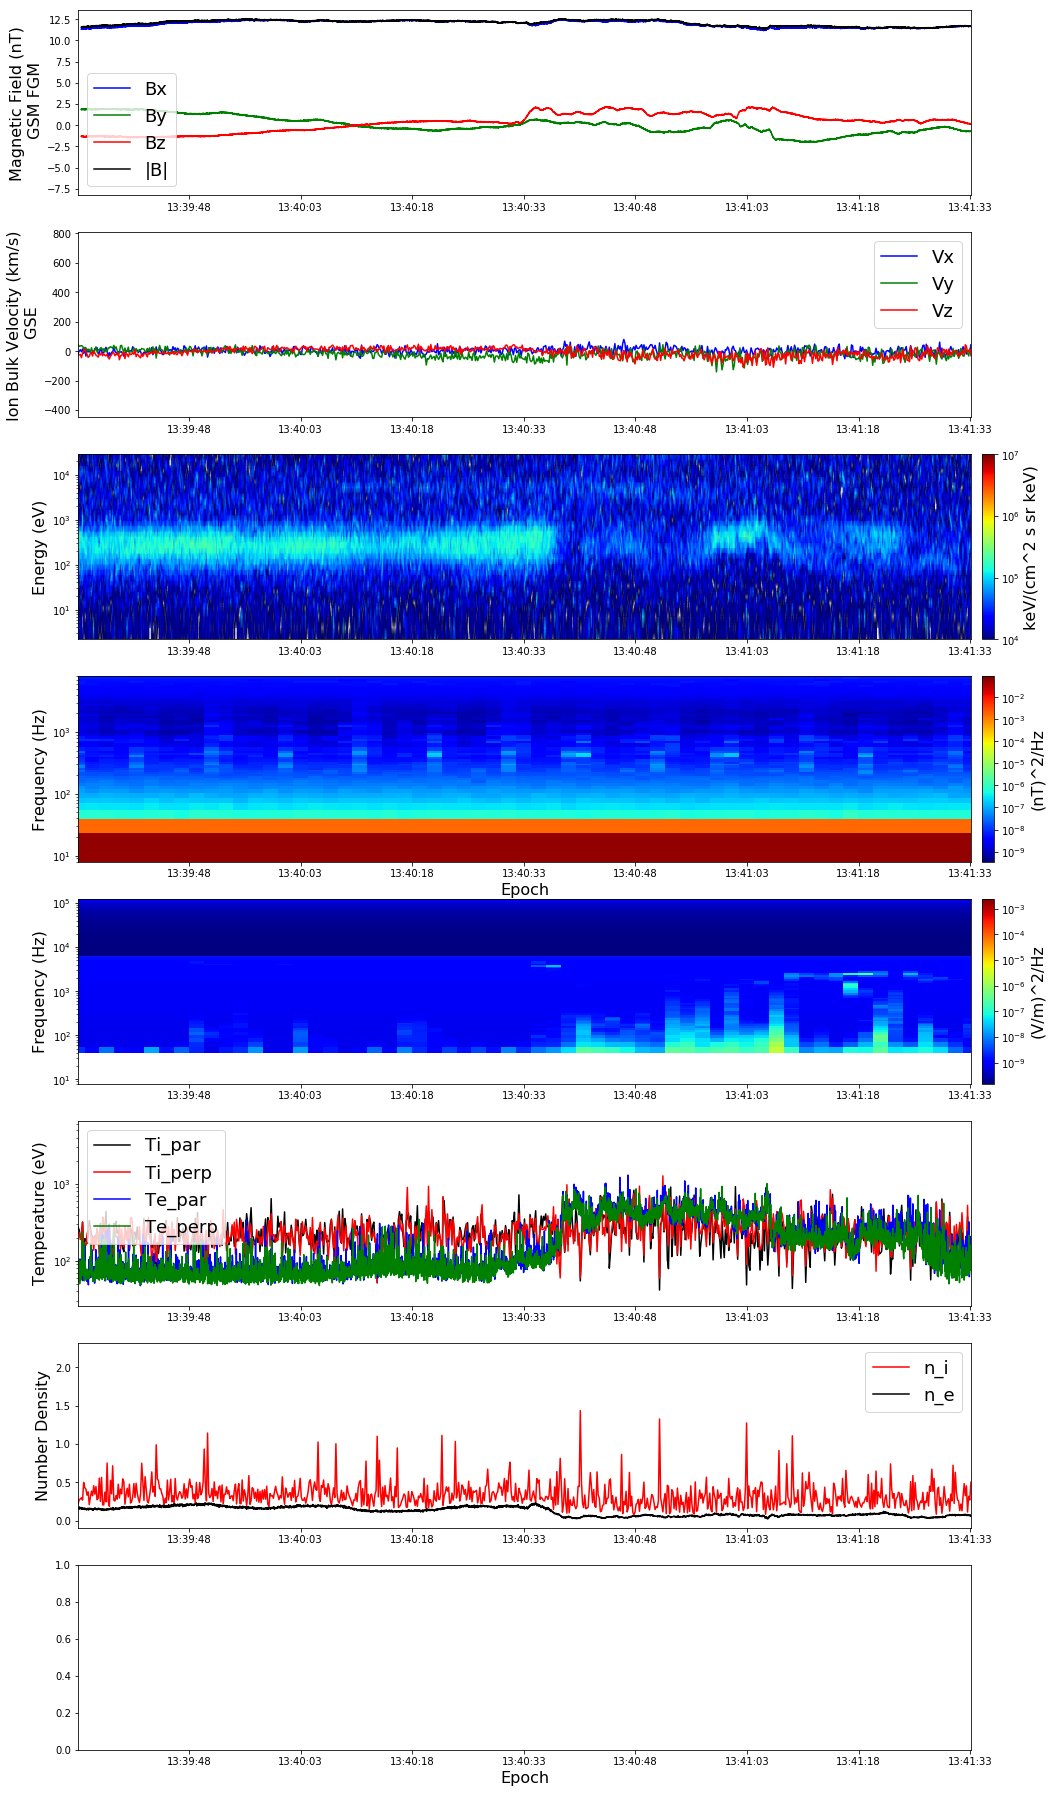

In [74]:
N = 8
fig  = plt.figure(figsize=(16,N*4))
ax1  = fig.add_subplot(N,1,1)               #mag field
ax2  = fig.add_subplot(N,1,2,sharex=ax1)    #ion bulk v
ax3  = fig.add_subplot(N,1,3,sharex=ax1)    #dis omni E-t spectrogram
ax4  = fig.add_subplot(N,1,4,sharex=ax1)    #bfield psd
ax5  = fig.add_subplot(N,1,5,sharex=ax1)    #efield psd
ax6  = fig.add_subplot(N,1,6,sharex=ax1)    #perp and par temperatures
ax7  = fig.add_subplot(N,1,7,sharex=ax1)    #density
ax8  = fig.add_subplot(N,1,8,sharex=ax1)    #plasma beta
flag = 0
imoms_min = 4
imoms_max = 7
emoms_min = 4
emoms_max = 8
for d in range(len(Be)):
    if flag == 0:
        ax1.plot(Bfgm[d]['epochs'],Bfgm[d]['Bgsm'][:,0],'b-',label='Bx')
        ax1.plot(Bfgm[d]['epochs'],Bfgm[d]['Bgsm'][:,1],'g-',label='By')
        ax1.plot(Bfgm[d]['epochs'],Bfgm[d]['Bgsm'][:,2],'r-',label='Bz')
        ax1.plot(Bfgm[d]['epochs'],Bfgm[d]['Bgsm'][:,3],'k-',label='|B|')        
        ax2.plot(Bi[d]['epochs'],Bi[d]['bulk_vs'][:,0],'b-',label='Vx')
        ax2.plot(Bi[d]['epochs'],Bi[d]['bulk_vs'][:,1],'g-',label='Vy')
        ax2.plot(Bi[d]['epochs'],Bi[d]['bulk_vs'][:,2],'r-',label='Vz')
        ax6.plot(Bi[d]['epochs'],Bi[d]['T_par'],'k-',label='Ti_par')
        ax6.plot(Bi[d]['epochs'],Bi[d]['T_perp'],'r-',label='Ti_perp')        
        ax6.plot(Be[d]['epochs'],Be[d]['T_par'],'b-',label='Te_par')
        ax6.plot(Be[d]['epochs'],Be[d]['T_perp'],'g-',label='Te_perp')  
        ax7.plot(Bi[d]['epochs'],Bi[d]['num_den'],'r-',label='n_i')
        ax7.plot(Be[d]['epochs'],Be[d]['num_den'],'k-',label='n_e')        
        flag = 1
    else:
        ax1.plot(Bfgm[d]['epochs'],Bfgm[d]['Bgsm'][:,0],'b-')
        ax1.plot(Bfgm[d]['epochs'],Bfgm[d]['Bgsm'][:,1],'g-')
        ax1.plot(Bfgm[d]['epochs'],Bfgm[d]['Bgsm'][:,2],'r-')
        ax1.plot(Bfgm[d]['epochs'],Bfgm[d]['Bgsm'][:,3],'k-')        
        ax2.plot(Bi[d]['epochs'],Bi[d]['bulk_vs'][:,0],'b-')
        ax2.plot(Bi[d]['epochs'],Bi[d]['bulk_vs'][:,1],'g-')
        ax2.plot(Bi[d]['epochs'],Bi[d]['bulk_vs'][:,2],'r-')
        ax6.plot(Bi[d]['epochs'],Bi[d]['T_par'],'k-')
        ax6.plot(Bi[d]['epochs'],Bi[d]['T_perp'],'r-')                
        ax6.plot(Be[d]['epochs'],Be[d]['T_par'],'b-')
        ax6.plot(Be[d]['epochs'],Be[d]['T_perp'],'g-')
        ax7.plot(Bi[d]['epochs'],Bi[d]['num_den'],'r-')
        ax7.plot(Be[d]['epochs'],Be[d]['num_den'],'k-')        
    cbpatch3 = ax3.pcolormesh(Bi[d]['epochs'],\
                              dis_ergs,\
                              np.ma.masked_invalid(np.log10(Bi[d]['omnis'].T)),\
                              cmap=cmap.jet,\
                              shading='gouraud',
                              vmin = imoms_min,
                              vmax = imoms_max)
#xmin,xmax = ax1.get_xlim()   

cbpatch4 = ax4.pcolormesh(bpsd_Epoch,bpsd_freq,bpsd_omni,cmap=cmap.jet)
cbpatch5 = ax5.pcolormesh(epsd_Epoch,epsd_freq,epsd_omni,cmap=cmap.jet)

cb3ax = fig.add_axes(Grapher.cbar_position(ax3,0.01,0.01))
cb4ax = fig.add_axes(Grapher.cbar_position(ax4,0.01,0.01))
cb5ax = fig.add_axes(Grapher.cbar_position(ax5,0.01,0.01))

fig.colorbar(cbpatch3,cax=cb3ax,ticks=np.array(range(imoms_min,imoms_max+1)),format=ticker.FormatStrFormatter('$10^{%d}$'))
fig.colorbar(cbpatch4,cax=cb4ax,format=ticker.FormatStrFormatter('$10^{%d}$'))
fig.colorbar(cbpatch5,cax=cb5ax,format=ticker.FormatStrFormatter('$10^{%d}$'))

ax1.set_ylabel('Magnetic Field (nT)\n GSM FGM',fontsize=16)
ax1.legend(fontsize=18)    

ax2.set_ylabel('Ion Bulk Velocity (km/s)\n GSE',fontsize=16)
ax2.legend(fontsize=18)    

ax3.set_yscale('log')        
ax3.set_ylabel('Energy (eV)',fontsize=16)
cb3ax.set_ylabel('keV/(cm^2 s sr keV)',fontsize=16)

ax4.set_yscale('log')
ax4.set_ylim([bpsd_freq[0],bpsd_freq[-1]])
ax4.set_xlabel('Epoch',fontsize=16)
ax4.set_ylabel('Frequency (Hz)',fontsize=16)
cb4ax.set_ylabel('(nT)^2/Hz',fontsize=16)
#ax4.set_xlim([xmin,xmax])

ax5.set_yscale('log')
ax5.set_ylim([epsd_freq[0],epsd_freq[-1]])
ax5.set_ylabel('Frequency (Hz)',fontsize=16)
cb5ax.set_ylabel('(V/m)^2/Hz',fontsize=16)

ax6.set_yscale('log')
ax6.set_ylabel('Temperature (eV)',fontsize=16)
ax6.legend(fontsize=18)    

ax7.set_yscale('linear')
ax7.set_ylabel('Number Density',fontsize=16)
ax7.legend(fontsize=18)    

ax8.set_xlabel('Epoch',fontsize=16)

ax1.set_xlim([mpl.dates.date2num(starttime),mpl.dates.date2num(stoptime)])

plt.show()

In [84]:
print Be[0]['num_den'][18], Bi[0]['num_den'][0]

0.173392 0.223119


In [24]:
P = np.array([np.trace(Be[0]['pres_s'][i]) for i in range(len(Be[0]['epochs']))])
print P.shape

(23999,)


In [25]:
P[0]

0.0043374272

In [15]:
Be[0]['trace_p'][0]

0.0043374272

In [37]:
Be[0]['epochs'][17]

datetime.datetime(2017, 6, 8, 13, 39, 33, 511312)

In [17]:
Bfgm[0]['epochs'][0]

datetime.datetime(2017, 6, 8, 13, 39, 33, 513035)

In [19]:
epoch_strings[0]

'20170608133933'

In [28]:
mag_CDF = pycdf.CDF(munge.fgm_dir+munge.fgm_pre+epoch_strings[0]+munge.fgm_post)

In [38]:
munge.fgm_dir+munge.fgm_pre+epoch_strings[0]+munge.fgm_post

'/fpiprd1/fpishare/Conrad/Yuggoth/mms1/fgm/brst/l2/2017/06/08/mms1_fgm_brst_l2_20170608133933_v5.92.0.cdf'

In [42]:
emoms_file = munge.fpi_emoms_dir+munge.fpi_emoms_pre+epoch_strings[0]+munge.fpi_post

In [83]:
#emoms = pycdf.CDF(emoms_file)
print emoms['Epoch'][18], emoms['mms1_des_numberdensity_brst'][18]

2017-06-08 13:39:33.541312 0.173391908407


In [68]:
print Be[0]['epochs'][0], Be[0]['num_den'][0]
print Bi[0]['epochs'][0], Bi[0]['num_den'][0]

2017-06-08 13:39:33.001312 0.165921
2017-06-08 13:39:33.091312 0.223119


In [32]:
PAD.bisect_epochs(Be[0]['epochs'][0],Bfgm[0]['epochs'])

(0, 1)

In [75]:
def bisect_epochs(target_epoch,epochs):

    #test to make sure that target_epoch falls within the epochs array
    #if not send back identical indices (start or end)
    if (target_epoch - epochs[0]).total_seconds() < 0.0:
        return 0,0
    if (target_epoch - epochs[-1]).total_seconds() > 0.0:
        return len(epochs), len(epochs)
    
    #bisect to find bracketing points
    low_index  = 0
    high_index = len(epochs)
    
    old_trial_index = low_index
    trial_index     = high_index
    
    counter = 0
    while( abs(old_trial_index - trial_index) > 1 ):
        old_trial_index = trial_index
        trial_index     = np.int(np.floor((high_index+low_index)/2.0))
        trial_epoch     = epochs[trial_index]
        if (trial_epoch - target_epoch).total_seconds() < 0.0:
            low_index  = trial_index
        else:
            high_index = trial_index
        print counter, low_index, high_index, trial_index
        counter += 1

    #a test for what may happen for an odd number of points 
    #in the epochs array
    if(high_index == low_index):
        #find out if the common epoch is above or below the target
        if (epochs[high_index] - target_epoch).total_seconds() < 0.0:
            high_index = high_index + 1
        else:
            low_index = low_index - 1
            
    return low_index, high_index

In [79]:
N = 18
bisect_epochs(Be[0]['epochs'][N],Bfgm[0]['epochs'])

0 0 46016 46016
1 0 23008 23008
2 0 11504 11504
3 0 5752 5752
4 0 2876 2876
5 0 1438 1438
6 0 719 719
7 0 359 359
8 0 179 179
9 0 89 89
10 0 44 44
11 0 22 22
12 0 11 11
13 0 5 5
14 2 5 2
15 3 5 3


(3, 5)

In [80]:
print Bfgm[0]['epochs'][3], Bfgm[0]['epochs'][4], Bfgm[0]['epochs'][5], Be[0]['epochs'][N]

2017-06-08 13:39:33.536473 2017-06-08 13:39:33.544286 2017-06-08 13:39:33.552098 2017-06-08 13:39:33.541312
